This notebook is part of an exploratory analysis of machine learning used to decompose hyperspectral datasets of hybrid perovskite nanoscale materials.

Two machine learning models are used: Nonnegative Matrix Factorization and Variational Autoencoders

**Notebook Five: Semi-Supervised VAE Using Keras**

# Imports, Functions, and Classes

## Imports

In [1]:
import import_ipynb
from ML_HSI_Analysis_1_Preprocessing import *

importing Jupyter notebook from ML_HSI_Analysis_1_Preprocessing.ipynb
SEM images: f1_img1, f2_img1
CL images: f1_img2, f2_img2
Denoised data: f1_sb_median, f2_sb_median
2D denoised data: f1_denoised_2d, f2_denoised_2d


In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Variational Autoencoder

An autoencoder is an unsupervised neural network model that learns two functions: an encoding function (transforms input into latent space representation with lower dimensionality) and a decoding function (recreates input data from latent representation). The autoencoder attempts to optimize the representation of unbalanced/non-linear data (as opposed to PCA or NMF, which are linear). It is more deterministic in its approach than a VAE.

Hyperparameters: Code size, number of layers, number of nodes per layer, and the loss function

Architecture: Input, encoder, latent space, decoder, and output

A variational autoencoder is a generative, semi-supervised autoencoder with the addition of regularized training (which prevents overfitting). This crucial additional step allows for each point in the latent space to yield meaningful data, allowing for generative processes. These are more probabilistic in nature and enforce a (generally Gaussian) distribution in the sampling process. The end result is a latent space that is optimized for clustering together similar data points while giving a continuous distribution across the entire latent space. This is achieved through minimizing the KL divergence (causing the mean to approach 0 and the standard deviation to approach 1).

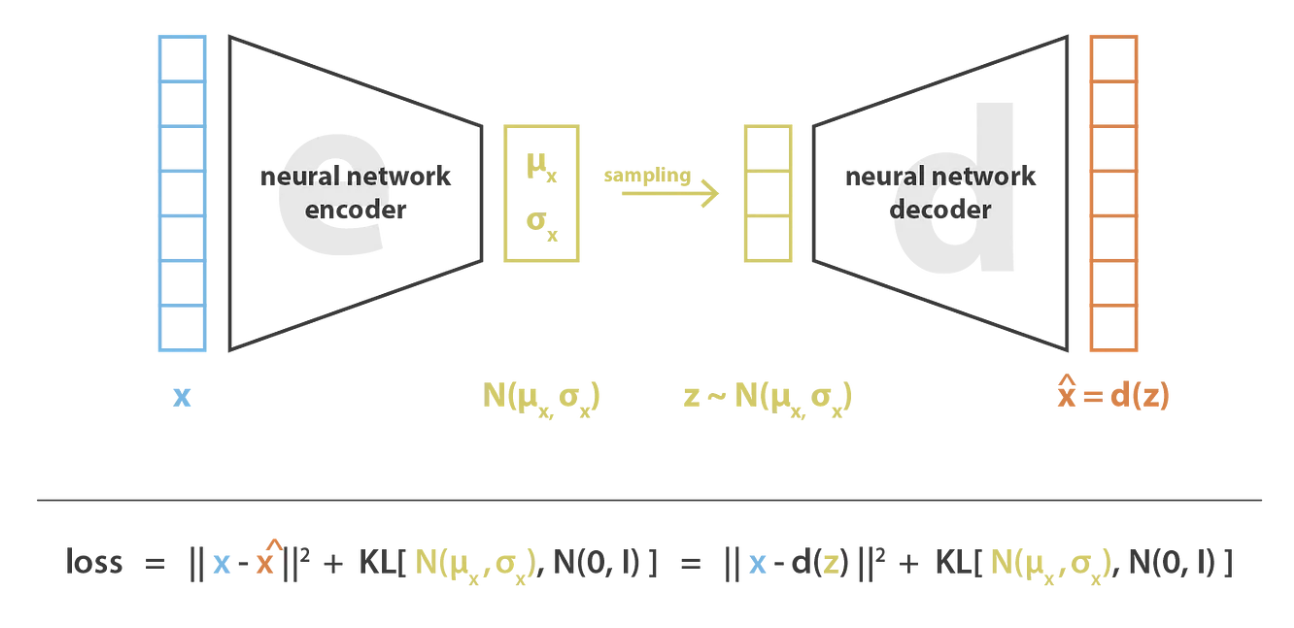

Loss function: reconstruction term (Gradient descent) (makes encoding and decoding efficient) + regularization term (Kullback-Liebler Divergence) (creates regular latent space)

VAE's use a "reparameterization trick" to allow for backpropogation, which is impossible through a stochastic node. The process of sampling from a distribution that is parameterized by the model is not differentiable, and this is a problem for gradient-based approches. There must be a method of making the predictions separate from the stochastic sampling element.

It accomplishes this by treating random sampling as a noise term which is now independent and not parameterized by the model. A Gaussian can be scaled by a sample from the noise distribution multiplied by the standard deviation added to the mean. This allows for further differentiation through the model.

We are primarily interested in the latent space representation of the data as this reveals to us the correlations in the data that the model detects. However many latent dimensions we specify in the training will be the number of principal components we analyze and their correlaitons to one another.

Semi-supervised machine learning involves aspects of both supervised and unsupervisded machine learning. A small portion of the training data is labeled, and this is used to classify the majority of the data, which is unlabeled. The goal here is to label several spectral features within the data and asses how well the model is able to pick up on the locations of these features through training in order to predict their location in new data.

## Plot Code

This builds a plot of the latent space dimensions with two or three latent dimensions and plots points corresponding to single pixels in the x and y axes of the original dataset. The point is to show a relationship between different spectral features detected by the autoencoder.

Below this plot are image components of the latent representation of the data.

In [3]:
def vae_plot(z_mean, xpix, ypix, scalebar_size):
    
    rows = 2
    columns = len(z_mean[0])
    
    cmap = mpl.colormaps['viridis']
    fig = plt.figure(figsize=(8,8), dpi=600)
    if columns == 3:
        gs = GridSpec(rows, columns, top=0.5)
    else:
        gs = GridSpec(rows, columns)
    #gs_top = GridSpec(rows, columns, top=0.99)
    #gs_base = GridSpec(rows, columns, wspace=0.3, hspace=0.03, top=0.8, bottom=0.3)
    #gs_top.tight_layout(fig)
    #gs_base.tight_layout(fig)
    fig.patch.set_facecolor('white')
    
    for i in range(rows):
        column_count = 0
        for j in range(columns):
            if i == 0:
                if columns == 2:
                    ax = fig.add_subplot(gs[0,column_count])
                    ax.scatter(z_mean[:,0], z_mean[:,1], c=z_mean[:,column_count], cmap=cmap,
                            ec='black', lw=0.2, alpha=0.6, s=3)
                    ax.set_xticks([0.25, 0.5, 0.75, 1])
                    ax.set_yticks([0.25, 0.5, 0.75, 1])
                    ax.set_xticklabels([0.25, 0.5, 0.75, 1], fontsize=5)
                    ax.set_yticklabels([0.25, 0.5, 0.75, 1], fontsize=5)
                if columns == 3:
                    ax = fig.add_subplot(gs[0,column_count], projection='3d')
                    ax.scatter(z_mean[:,0], z_mean[:,1], z_mean[:,2], 
                            c=z_mean[:,column_count], cmap=cmap,
                            ec='black', lw=0.05, alpha=0.5, s=3)
                    ax.set_xticks([0.25, 0.5, 0.75, 1])
                    ax.set_yticks([0.25, 0.5, 0.75, 1])
                    ax.set_zticks([0.25, 0.5, 0.75, 1])
                    ax.set_xticklabels([])
                    ax.set_yticklabels([])
                    ax.set_zticklabels([])
                    ax.set_xlabel("X", size=10, labelpad=-15)
                    ax.set_ylabel("Y", size=10, labelpad=-15)
                    ax.set_zlabel("Z", size=10, labelpad=-15)
                    #ax.set_zticklabels([0.25, 0.5, 0.75, 1], fontsize=5)
                    if j == 0:
                        ax.view_init(30, -90) 
                    elif j == 1:
                        ax.view_init(30, -30)
                    elif j == 2:
                        ax.view_init(30, 30)
                ax.tick_params(axis='both', which='minor', labelsize=20, direction='out', 
                               length=12, width=4)
                if column_count == 0:
                    ax.set_title('Latent Space', size=20)
            
            if i == 1:
                img = fig.add_subplot(gs[1,column_count])
                img.imshow(z_mean[:,column_count].reshape(ypix, xpix), cmap=cmap)
                img.set_xticks([])
                img.set_yticks([])
                
                if column_count == (columns-1):
                    scalebar = AnchoredSizeBar(img.transData, scalebar_size, " ", 
                            "lower right", pad=0.3, color='#F2F2F2', frameon=False,
                                               size_vertical=3, label_top=True)
                    img.add_artist(scalebar)

            column_count += 1
    
    #fig.savefig('VAE/3.2) Figure 1, Y-axis spectra (batch size 256).png')

In [4]:
# Spectra Plot (For determining latent dimensions)
def spectra_plot(img2, array, xpix, ypix, wav, title):
    
    n = xpix*ypix # total number of spectra
    cmap = mpl.colormaps['viridis'](np.linspace(0,1,n)) # create colormap
    fig = plt.figure(figsize=(8,8), dpi=600)
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot()
    ax.set_prop_cycle('color', list(cmap)) # colormaps each spectra from first to last in array
    ax.set_title(title, size=20)
    plt.xlim(spect_range_b, spect_range_t)
    #ax.set_xticks([500, 750])
    #ax.set_xticklabels([])
    #plt.yscale('log')
    
    for i in array:
        ax.plot(wav, img2[:,i[0],i[1]], lw=0.3, alpha=0.5)
    
    #fig.savefig('VAE/4.3) Figure 1, 3D, Z-axis spectra (batch size 256).png')

An attempt to create my own manifold. The manifold uses the continuous representation of the data's features in the latent space to generate its own spectra (to an infinitesimal degree). This is to help determine what features each axis corresponds to.

### Manifold

In [5]:
def generate_latent_grid(d: int, **kwargs) -> torch.Tensor:
    """
    Generates a grid of latent space coordinates
    """
    if isinstance(d, int):
        d = [d, d]
    z_coord = kwargs.get("z_coord")
    if z_coord:
        z1, z2, z3, z4 = z_coord
        grid_x = torch.linspace(z2, z1, d[0])
        grid_y = torch.linspace(z3, z4, d[1])
    else:
        grid_x = dist.Normal(0, 1).icdf(torch.linspace(0.95, 0.05, d[0]))
        grid_y = dist.Normal(0, 1).icdf(torch.linspace(0.05, 0.95, d[1]))
    z = []
    for xi in grid_x:
        for yi in grid_y:
            z.append(tt([xi, yi]).float().unsqueeze(0))
    return torch.cat(z), (grid_x, grid_y)

In [6]:
def plot_img_grid(imgdata: torch.Tensor, d: int,
                  **kwargs: Union[str, int, List[float]]) -> None:
    """
    Plots a *d*-by-*d* square grid of 2D images
    """
    if imgdata.ndim < 3:
        raise AssertionError("Images must be passed as a 3D or 4D tensor")
    imgdata = imgdata[:, None] if imgdata.ndim == 3 else imgdata
    grid = make_grid(imgdata, nrow=d,
                     padding=kwargs.get("padding", 2),
                     pad_value=kwargs.get("pad_value", 0)).cpu()
    extent = kwargs.get("extent")
    # Put on cpu in case all tensors are created on gpu by default
    extent_ = [e.cpu() for e in extent]
    plt.figure(figsize=(8, 8))
    plt.imshow(grid[0].squeeze(), cmap=kwargs.get("cmap", "gnuplot"),
               origin=kwargs.get("origin", "upper"),
               extent=extent_)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18)
    plt.show()

In [7]:
def plot_spect_grid(spectra: torch.Tensor, d: int, **kwargs: List[float]):  # TODO: Add 'axes' and 'extent'
    """
    Plots a *d*-by-*d* square grid with 1D spectral plots
    """
    _, axes = plt.subplots(d, d, figsize=(8, 8),
                           subplot_kw={'xticks': [], 'yticks': []},
                           gridspec_kw=dict(hspace=0.1, wspace=0.1))
    ylim = kwargs.get("ylim")
    spectra = spectra.cpu()
    for ax, y in zip(axes.flat, spectra):
        ax.plot(y.squeeze(), color=color[ax])
        if ylim:
            ax.set_ylim(*ylim)
    plt.show()

In [8]:
"""
ivae.py
=======

Variational autoencoder that enforces invariance to
rotation, translation, and scale

Created by Maxim Ziatdinov (email: ziatdinovmax@gmail.com)
"""


class iVAE(baseVAE):
    """
    Variational autoencoder that enforces rotational, translational,
    and scale invariances.

    Args:
        data_dim:
            Dimensionality of the input data; use (height x width) for images
            or (length,) for spectra.
        latent_dim:
            Number of latent dimensions.
        invariances:
            List with invariances to enforce. For 2D systems, `r` enforces
            rotational invariance, `t` enforces invariance to
            translations, `sc` enforces a scale invariance, and
            invariances=None corresponds to vanilla VAE.
            For 1D systems, 't' enforces translational invariance and
            invariances=None is vanilla VAE
        c_dim:
            "Feature dimension" of the c vector in p(z|c) where z is
            explicitly conditioned on variable c. The latter can be continuous
            or discrete. For example, to train a class-conditional VAE on
            a dataset with 10 classes, the c_dim must be equal to 10 and
            the corresponding n x 10 vector should represent one-hot encoded labels.
            (The default c_dim value is 0, i.e. no conditioning is performed).
        hidden_dim_e:
            List with the number of hidden units per each layer in encoder (inference
            network). Defaults to [128, 128].
        hidden_dim_d:
            List with the number of hidden units per each layer in decoder (generator
            network). Defaults to [128, 128].
        activation:
            Non-linear activation for inner layers of encoder and decoder.
            The available activations are ReLU ('relu'), leaky ReLU ('lrelu'),
            hyberbolic tangent ('tanh'), softplus ('softplus'), and GELU ('gelu').
            (The default is 'tanh').
        sampler_d:
            Decoder sampler, as defined as p(x|z) = sampler(decoder(z)).
            The available samplers are 'bernoulli', 'continuous_bernoulli',
            and 'gaussian'. (The default is "bernoulli").
        sigmoid_d:
            Sigmoid activation for the decoder output. (The default is True).
        seed:
            Seed used in torch.manual_seed(seed) and
            torch.cuda.manual_seed_all(seed). (The default is 1).

    Keyword Args:
        device:
            Sets device to which model and data will be moved.
            Defaults to 'cuda:0' if a GPU is available and to CPU otherwise.
        dx_prior:
            Translational prior in x direction (float between 0 and 1)
        dy_prior:
            Translational prior in y direction (float between 0 and 1)
        sc_prior:
            Scale prior (usually, sc_prior << 1)
        decoder_sig:
            Sets sigma for a "gaussian" decoder sampler

    Examples:
        Example 1. Initialize and train a VAE model with rotational invariance

        >>> import pyroved as pv
        >>> # Initialize VAE model
        >>> data_dim = (28, 28)
        >>> rvae = iVAE(data_dim, latent_dim=2, invariances=['r'])
        >>> # Create a dataloader object
        >>> train_loader = pv.utils.init_dataloader(train_data, batch_size=200)
        >>> # Initialize SVI trainer
        >>> trainer = pv.trainers.SVItrainer(rvae)
        >>> # Train for 100 epochs
        >>> for e in range(100)
        >>>     trainer.step(train_loader)
        >>>     trainer.print_statistics() # print running loss
        >>> # After training is complete, we can visualize the learned latent manifold
        >>> rvae.manifold2d(d=12, cmap='viridis');

        Example 2. Initialize a class-conditional VAE model with
        rotational and translational invarainces for dataset that has 10 classes

        >>> data_dim = (28, 28)
        >>> rvae = iVAE(data_dim, latent_dim=2, c_dim=10, invariances=['r', 't'])
        >>> # Create a dataloader object consisting of training images and class labels
        >>> train_loader = pv.utils.init_dataloader(train_data, train_labels, batch_size=200)
        >>> # Initialize SVI trainer
        >>> trainer = pv.trainers.SVItrainer(rvae)
        >>> # Train for 100 epochs
        >>> for e in range(100)
        >>>     trainer.step(train_loader)
        >>>     trainer.print_statistics() # print running loss
        >>> # Visualize the learned latent manifold for a specific class
        >>> cls = pv.utils.to_onehot(torch.tensor([5,]), 10)
        >>> rvae.manifold2d(d=12, cls, cmap='viridis');
    """

    def __init__(
        self,
        data_dim: Tuple[int],
        latent_dim: int = 2,
        invariances: List[str] = None,
        c_dim: int = 0,
        hidden_dim_e: List[int] = None,
        hidden_dim_d: List[int] = None,
        activation: str = "tanh",
        sampler_d: str = "bernoulli",
        sigmoid_d: bool = True,
        seed: int = 1,
        **kwargs: Union[str, float]
         ) -> None:
        args = (data_dim, invariances)
        super(iVAE, self).__init__(*args, **kwargs)

        # Reset the pyro ParamStoreDict object's dictionaries
        pyro.clear_param_store()
        # Set all torch manual seeds
        set_deterministic_mode(seed)

        # Initialize the encoder network
        self.encoder_z = fcEncoderNet(
            data_dim, latent_dim + self.coord, c_dim, hidden_dim_e,
            activation, softplus_out=True
        )
        # Initialize the decoder network
        dnet = sDecoderNet if 0 < self.coord < 5 else fcDecoderNet
        self.decoder = dnet(
            data_dim, latent_dim, c_dim, hidden_dim_d,
            activation, sigmoid_out=sigmoid_d
        )
        # Initialize the decoder's sampler
        self.sampler_d = get_sampler(sampler_d, **kwargs)

        # Sets continuous and discrete dimensions
        self.z_dim = latent_dim + self.coord
        self.c_dim = c_dim

        # Move model parameters to appropriate device
        self.to(self.device)

    def model(self,
              x: torch.Tensor,
              y: Optional[torch.Tensor] = None,
              **kwargs: float) -> None:
        """
        Defines the model p(x|z)p(z) (or p(x|z,y) if y is not None)
        """
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        # KLD scale factor (see e.g. https://openreview.net/pdf?id=Sy2fzU9gl)
        beta = kwargs.get("scale_factor", 1.)
        reshape_ = torch.prod(torch.tensor(x.shape[1:])).item()
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            with pyro.poutine.scale(scale=beta):
                z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            if self.coord > 0:  # rotationally- and/or translationaly-invariant mode
                # Split latent variable into parts for rotation
                # and/or translation and image content
                phi, dx, sc, z = self.split_latent(z)
                if 't' in self.invariances:
                    dx = (dx * self.t_prior).unsqueeze(1)
                # transform coordinate grid
                grid = self.grid.expand(x.shape[0], *self.grid.shape)
                x_coord_prime = transform_coordinates(grid, phi, dx, sc)
            # Add class label (if any)
            if y is not None:
                z = torch.cat([z, y], dim=-1)
            # decode the latent code z together with the transformed coordinates (if any)
            dec_args = (x_coord_prime, z) if self.coord else (z,)
            loc = self.decoder(*dec_args)
            # score against actual images ("binary cross-entropy loss")
            pyro.sample(
                "obs", self.sampler_d(loc.view(-1, reshape_)).to_event(1),
                obs=x.view(-1, reshape_))

    def guide(self,
              x: torch.Tensor,
              y: Optional[torch.Tensor] = None,
              **kwargs: float) -> None:
        """
        Defines the guide q(z|x) (or q(z|x,y) if y is not None)
        """
        # register PyTorch module `encoder_z` with Pyro
        pyro.module("encoder_z", self.encoder_z)
        # KLD scale factor (see e.g. https://openreview.net/pdf?id=Sy2fzU9gl)
        beta = kwargs.get("scale_factor", 1.)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            enc_args = [x, y] if y is not None else x
            z_loc, z_scale = self.encoder_z(enc_args)
            # sample the latent code z
            with pyro.poutine.scale(scale=beta):
                pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def split_latent(self, z: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        Split latent variable into parts associated with coordinate transformations
        (rotation and/or transaltion and/or scale) and image content.
        """
        return self._split_latent(z)

    def encode(self,
               x_new: torch.Tensor,
               y: torch.Tensor = None,
               **kwargs: int) -> torch.Tensor:
        """
        Encodes data using a trained inference (encoder) network. The output is
        a tuple with means and standard deviations of the encoded distributions.
        The last n dimensions of the produced latent vectors, z[-n:], correspond
        to "conventional" n latent variables specified at the model initialization stage
        as 'latent_dim'. The remaining dimensions, z[:-n], correspond to "special"
        latent variables (if any) associated with transformations of image/spectrum
        coordinates and start with rotation, followed by dx and dy
        translations, and scale.

        Args:
            x_new:
                Data to encode with a trained (i)VAE model. The new data must have
                the same dimensions (images height and width or spectra length)
                as the one used for training.
            y: Conditional "property" vector (e.g. one-hot encoded classes)
            kwargs:
                Batch size as 'batch_size' (for encoding large volumes of data)
        """
        enc_args = [x_new, y] if y is not None else [x_new,]
        z = self._encode(*enc_args, **kwargs)
        z_loc, z_scale = z.split(self.z_dim, 1)
        return z_loc, z_scale

    def decode(self,
               z: torch.Tensor,
               y: torch.Tensor = None,
               **kwargs: int) -> torch.Tensor:
        """
        Decodes a batch of latent coordinates into the data space using a trained
        generator (decoder) network.

        Args:
            z: Latent coordinates (without rotational and translational parts)
            y: Conditional "property" vector (e.g. one-hot encoded class vector)
            kwargs: Batch size as 'batch_size'
        """
        z = z.to(self.device)
        if y is not None:
            z = torch.cat([z, y.to(self.device)], -1)
        loc = self._decode(z, **kwargs)
        return loc

    def manifold2d(self, d: int,
                   y: torch.Tensor = None,
                   plot: bool = True,
                   **kwargs: Union[str, int, float]) -> torch.Tensor:
        """
        Plots a learned latent manifold in the data space

        Args:
            d: Grid size
            plot: Plots the generated manifold (Default: True)
            y: Conditional "property" vector (e.g. one-hot encoded class vector)
            kwargs: Keyword arguments include custom min/max values
                    for grid boundaries passed as 'z_coord'
                    (e.g. z_coord = [-3, 3, -3, 3]), 'angle' and
                    'shift' to condition a generative model on, and plot parameters
                    ('padding', 'pad_value', 'cmap', 'origin', 'ylim')
        """
        z, (grid_x, grid_y) = generate_latent_grid(d, **kwargs)
        z = [z]
        if self.c_dim > 0:
            if y is None:
                raise ValueError("To generate a manifold pass a conditional vector y") 
            y = y.unsqueeze(1) if 0 < y.ndim < 2 else y
            z = z + [y.expand(z[0].shape[0], *y.shape[1:])]
        loc = self.decode(*z, **kwargs)
        if plot:
            if self.ndim == 2:
                plot_img_grid(
                    loc, d,
                    extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
                    **kwargs)
            elif self.ndim == 1:
                plot_spect_grid(loc, d, **kwargs)
        return loc

### Other

In [9]:
"""
def vae_plot(z_mean, xpix, ypix, nmf_img_matrices):
    
    rows = len(z_mean[0])+1
    columns = 2
    
    cmap = mpl.colormaps['viridis_r']
    fig = plt.figure(figsize=(8,rows*4))
    gs = fig.add_gridspec(2, 1)
    gs_top = gs[0].subgridspec(1, 1, hspace=0.75)
    gs_base = gs[1].subgridspec(rows-1, columns, wspace=0.2, hspace=0.05)
    
    ax1 = fig.add_subplot(gs_top[0,:])
    ax1.scatter(z_mean[:,0], z_mean[:,1], c=z_mean[:,0], cmap=cmap, 
                ec='black', lw=0.5, alpha=.75, s=20)
    ax1.set_xlabel('$z_1$', size=20)
    ax1.set_ylabel('$z_2$', size=20)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax1.set_title('Latent Space', size=20)
    
    nmf_matrix = len(z_mean[0])-2
    row_count = 1
    
    for i in range(rows-1):

        ax2 = fig.add_subplot(gs_base[row_count-1,0])
        ax2.imshow(z_mean[:,row_count-2].reshape(ypix, xpix), cmap=cmap)
        ax2.set_xticks([])
        ax2.set_yticks([])
        if row_count == 1:
            ax2.set_title('VAE', size=20)

        ax3 = fig.add_subplot(gs_base[row_count-1,1])
        ax3.imshow(nmf_img_matrices[nmf_matrix][row_count-1].reshape(ypix, xpix), 
                   cmap='viridis')
        ax3.set_xticks([])
        ax3.set_yticks([])
        if row_count == 1:
            ax3.set_title('NMF', size=20)
            
        row_count += 1
    
"""

"\ndef vae_plot(z_mean, xpix, ypix, nmf_img_matrices):\n    \n    rows = len(z_mean[0])+1\n    columns = 2\n    \n    cmap = mpl.colormaps['viridis_r']\n    fig = plt.figure(figsize=(8,rows*4))\n    gs = fig.add_gridspec(2, 1)\n    gs_top = gs[0].subgridspec(1, 1, hspace=0.75)\n    gs_base = gs[1].subgridspec(rows-1, columns, wspace=0.2, hspace=0.05)\n    \n    ax1 = fig.add_subplot(gs_top[0,:])\n    ax1.scatter(z_mean[:,0], z_mean[:,1], c=z_mean[:,0], cmap=cmap, \n                ec='black', lw=0.5, alpha=.75, s=20)\n    ax1.set_xlabel('$z_1$', size=20)\n    ax1.set_ylabel('$z_2$', size=20)\n    ax1.tick_params(axis='both', which='major', labelsize=20)\n    ax1.set_title('Latent Space', size=20)\n    \n    nmf_matrix = len(z_mean[0])-2\n    row_count = 1\n    \n    for i in range(rows-1):\n\n        ax2 = fig.add_subplot(gs_base[row_count-1,0])\n        ax2.imshow(z_mean[:,row_count-2].reshape(ypix, xpix), cmap=cmap)\n        ax2.set_xticks([])\n        ax2.set_yticks([])\n        if 

## Data preparation

In [5]:
f1_denoised_1d_transpose = f1_denoised_2d.transpose(1,0).reshape(f1_zpix*f1_ypix*f1_xpix)
f1_denoised_2d_norm = normalize(f1_denoised_1d_transpose).reshape(f1_ypix*f1_xpix, f1_zpix)

f1_denoised_2d_norm_t = torch.from_numpy(np.array(f1_denoised_2d_norm).astype('float64')).float()
f1_n_samples = f1_denoised_2d_norm_t.size()[0] # number of spectral points
f1_l_signal = f1_denoised_2d_norm_t.size()[1] # number of spectra

f1_train_data = f1_denoised_2d_norm_t.clone()
f1_train_loader = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=64)

f1_in_dim = (f1_l_signal,)
f1_kl_scale = torch.linspace(start=.001, end=.01, steps=50)

In [6]:
f2_denoised_1d_transpose = f2_denoised_2d.transpose(1,0).reshape(f2_zpix*f2_ypix*f2_xpix)
f2_denoised_2d_norm = normalize(f2_denoised_1d_transpose).reshape(f2_ypix*f2_xpix, f2_zpix)
    
f2_denoised_2d_norm_t = torch.from_numpy(np.array(f2_denoised_2d_norm).astype('float64')).float()

f2_n_samples = f2_denoised_2d_norm_t.size()[0] # number of spectra
f2_l_signal = f2_denoised_2d_norm_t.size()[1] # number of spectral points

f2_train_data = f2_denoised_2d_norm_t.clone()
f2_train_loader = pv.utils.init_dataloader(f2_train_data.unsqueeze(1), batch_size=64)

f2_in_dim = (f2_l_signal,)
f2_kl_scale = torch.linspace(.001, .01, 50)

In [7]:
f1_denoised_3d_norm_t = f1_denoised_2d_norm_t.reshape(f1_ypix, f1_xpix, f1_zpix)

### Plot signatures

First, I found 6 examples of each of the 4 features present in the material, giving a labeled set of 24 spectra

In [8]:
def pointfinder_plot(img, x_pt, ypix, wav):
    
    rows = ypix
    columns = 1
    fig = plt.figure(figsize=(20, 4*rows))
    #fig.suptitle(suptitle, fontsize=30)
    gs = GridSpec(rows, columns)
    
    row_count = 0
    for i in range(rows):
        # img
        #fig_img = fig.add_subplot(gs[row_count,0])
        #fig_img.imshow(img[spect_point,:,:])
        #fig_img.set_title(str(cosmic_points[row_count]))
        #fig_img.plot(cosmic_points[row_count][2], cosmic_points[row_count][1], "X", 
                     #ms=10, c=color[row_count])

        # plt
        fig_plt = fig.add_subplot(gs[row_count,0])
        #fig_plt.set_title("Spectra")
        # Transposed
        #fig_plt.plot(wav, img[x_pt,i-1,:], 
                     #c=color[row_count], lw=5)
        # Original
        fig_plt.plot(wav, img[:,i,x_pt], 
                     c=color[row_count], lw=5)
        plt.text(220,350,str([i,x_pt]))
        
        
        row_count += 1

    gs.tight_layout(fig, rect=[0,0.03,1,0.95])
    plt.show()
    #fig.savefig('Graphs/svg/1.2.2) After removing cosmic rays.svg')

This plots every spectra on a line of pixels

In [14]:
#pointfinder_plot(f1_img2, 9, f1_ypix, f1_wav)

In [10]:
# arrays of points labeled 0 to 3
f1_pts0 = [[50,50], [40,23], [40,21], [113,69], [93,75], [80,73], [4,4], [1,5], [55,100], [42,92]]
f1_pts1 = [[65,10], [67,17], [68,17], [69,17], [70,17], [74,17], [53,7], [52,7], [54,7], [74,9]]
f1_pts2 = [[22,142], [95,72], [96,72], [96,73], [95,71], [9,65], [47,8], [45,7], [43,7], [48,8]]
f1_pts3 = [[89,53], [9,67], [72,9], [7,69], [95,69], [7,72], [46,4], [42,4], [55,7], [42,8]]
f1_pts = [f1_pts0, f1_pts1, f1_pts2, f1_pts3]

In [9]:
f1_denoised_3d = np.reshape(f1_sb_median, (f1_zpix, f1_ypix, f1_xpix), order='C')

In [11]:
def spectsig_plot(img, pts, wav):
    
    rows = len(pts[0])
    columns = 4
    gs = GridSpec(rows, columns)
    gs.update(wspace=0,hspace=0.2)

    figsize = (columns*4, rows*3)
    fig = plt.figure(figsize=figsize, dpi = 600)
    fig.patch.set_facecolor('#00000000')
    #fig.suptitle(suptitle, fontsize=30)
    #fig.subplots_adjust(top=0.95, bottom=0.1)

    row_count = 0
    for i in range(rows):

        column_count = 0
        for j in range(columns):

            fig_plt = fig.add_subplot(gs[i,j])
            fig_plt.plot(wav, img[pts[j][i][0],pts[j]
                                  [i][1],:], c=color[j], lw=3)
            #fig_plt.set_title(method_names[row_count] + point_names[column_count])
            #fig_plt.tick_params(color=color[j])
            plt.xlim(spect_range_b, spect_range_t) # Cropping the spectra shown in the plot
            fig_plt.tick_params(axis='both', direction='out', length=12, width=4)
            #fig_plt.set_xticks([])
            fig_plt.set_yticks([])
            
            #if column_count == 0:
                #fig_plt.set_yticks([1000])
                #fig_plt.set_yticklabels([])
                #fig_plt.tick_params(axis='y', direction='out', length=12, width=4)
            
            #if row_count == rows-1:
                #fig_plt.set_xticks([400-spect_range_b, 750-spect_range_b])
                #fig_plt.set_xticklabels([])
                #fig_plt.tick_params(axis='x', direction='out', length=12, width=4)

            column_count += 1

        row_count += 1
    
    #fig.savefig('Graphs/final/2.1b) Various denoising techniques (hspace).svg')
    plt.show()

Our four classes of spectra

In [18]:
#spectsig_plot(f1_denoised_3d_norm_t, f1_pts, f1_wav)

### Modeling

X_sup: 16 labeled spectra for supervised training

y_sup: one-hot labels for the spectra (tensor of same size as X_sup)

X_val: 8 labeled spectra for validation step

y_val: labels for validation step

X_unsup: the rest of the spectra, with the above spectra replaced with zeros

In [12]:
f1_denoised_3d_norm = normalize(f1_denoised_1d_transpose).reshape(f1_ypix, f1_xpix, f1_zpix)

In [13]:
# Labeled data
n_samples = len(f1_pts0)
n_sup = n_samples-3
n_val = 3
f1_X_sup = torch.stack((f1_denoised_3d_norm_t[f1_pts0[0][0],f1_pts0[0][1],:], 
                    f1_denoised_3d_norm_t[f1_pts0[1][0],f1_pts0[1][1],:],
                    f1_denoised_3d_norm_t[f1_pts0[2][0],f1_pts0[2][1],:],
                    f1_denoised_3d_norm_t[f1_pts0[3][0],f1_pts0[3][1],:],
                    f1_denoised_3d_norm_t[f1_pts0[4][0],f1_pts0[4][1],:],
                    f1_denoised_3d_norm_t[f1_pts0[5][0],f1_pts0[5][1],:],
                    f1_denoised_3d_norm_t[f1_pts0[6][0],f1_pts0[6][1],:],
                    f1_denoised_3d_norm_t[f1_pts1[0][0],f1_pts1[0][1],:], 
                    f1_denoised_3d_norm_t[f1_pts1[1][0],f1_pts1[1][1],:],
                    f1_denoised_3d_norm_t[f1_pts1[2][0],f1_pts1[2][1],:],
                    f1_denoised_3d_norm_t[f1_pts1[3][0],f1_pts1[3][1],:],
                    f1_denoised_3d_norm_t[f1_pts1[4][0],f1_pts1[4][1],:],
                    f1_denoised_3d_norm_t[f1_pts1[5][0],f1_pts1[5][1],:],
                    f1_denoised_3d_norm_t[f1_pts1[6][0],f1_pts1[6][1],:],
                    f1_denoised_3d_norm_t[f1_pts2[0][0],f1_pts2[0][1],:], 
                    f1_denoised_3d_norm_t[f1_pts2[1][0],f1_pts2[1][1],:],
                    f1_denoised_3d_norm_t[f1_pts2[2][0],f1_pts2[2][1],:],
                    f1_denoised_3d_norm_t[f1_pts2[3][0],f1_pts2[3][1],:],
                    f1_denoised_3d_norm_t[f1_pts2[4][0],f1_pts2[4][1],:],
                    f1_denoised_3d_norm_t[f1_pts2[5][0],f1_pts2[5][1],:],
                    f1_denoised_3d_norm_t[f1_pts2[6][0],f1_pts2[6][1],:],
                    f1_denoised_3d_norm_t[f1_pts3[0][0],f1_pts3[0][1],:], 
                    f1_denoised_3d_norm_t[f1_pts3[1][0],f1_pts3[1][1],:],
                    f1_denoised_3d_norm_t[f1_pts3[2][0],f1_pts3[2][1],:],
                    f1_denoised_3d_norm_t[f1_pts3[3][0],f1_pts3[3][1],:],
                    f1_denoised_3d_norm_t[f1_pts3[4][0],f1_pts3[4][1],:],
                    f1_denoised_3d_norm_t[f1_pts3[5][0],f1_pts3[5][1],:],
                    f1_denoised_3d_norm_t[f1_pts3[6][0],f1_pts3[6][1],:])).float()

f1_sup_labels = torch.cat([torch.zeros(n_sup), torch.ones(n_sup),
                           2*torch.ones(n_sup), 3*torch.ones(n_sup)])
f1_y_sup = pv.utils.to_onehot(f1_sup_labels.long(), n=4)

f1_X_val = torch.stack((f1_denoised_3d_norm_t[f1_pts0[7][0],f1_pts0[7][1],:], 
                    f1_denoised_3d_norm_t[f1_pts0[8][0],f1_pts0[8][1],:],
                    f1_denoised_3d_norm_t[f1_pts0[9][0],f1_pts0[8][1],:],
                    f1_denoised_3d_norm_t[f1_pts1[7][0],f1_pts1[7][1],:], 
                    f1_denoised_3d_norm_t[f1_pts1[8][0],f1_pts1[8][1],:],
                    f1_denoised_3d_norm_t[f1_pts1[9][0],f1_pts1[9][1],:],
                    f1_denoised_3d_norm_t[f1_pts2[7][0],f1_pts2[7][1],:], 
                    f1_denoised_3d_norm_t[f1_pts2[8][0],f1_pts2[8][1],:],
                    f1_denoised_3d_norm_t[f1_pts2[9][0],f1_pts2[9][1],:],
                    f1_denoised_3d_norm_t[f1_pts3[7][0],f1_pts3[7][1],:], 
                    f1_denoised_3d_norm_t[f1_pts3[8][0],f1_pts3[8][1],:],
                    f1_denoised_3d_norm_t[f1_pts3[9][0],f1_pts3[9][1],:])).float()

#f1_X_val = torch.cat(f1_X_val)
f1_val_labels = torch.cat([torch.zeros(n_val), torch.ones(n_val),
                           2*torch.ones(n_val), 3*torch.ones(n_val)])
f1_y_val = pv.utils.to_onehot(f1_val_labels.long(), n=4)

In [14]:
f1_X_unsup = f1_denoised_3d_norm_t
for i in range(n_samples):
    for j in range(4):
        f1_X_unsup[f1_pts[j][i][0],f1_pts[j][i][1],:] *= 0
f1_X_unsup = f1_X_unsup.reshape(f1_xpix*f1_ypix, f1_zpix)

In [22]:
# Random shuffling of points in imag
#f1_X_unsup = f1_X_unsup[torch.randperm(f1_X_unsup.size()[0])]

Below is an image of the hybrid perovskite cell divided into the spatial locations of the four spectral feautures I chose to label before running the model

### Labels

In [15]:
f1_ssvae_0_labels = (f1_ssvae_z_labels_2d == 0).nonzero(as_tuple=False)
f1_ssvae_1_labels = (f1_ssvae_z_labels_2d == 1).nonzero(as_tuple=False)
f1_ssvae_2_labels = (f1_ssvae_z_labels_2d == 2).nonzero(as_tuple=False)
f1_ssvae_3_labels = (f1_ssvae_z_labels_2d == 3).nonzero(as_tuple=False)

NameError: name 'f1_ssvae_z_labels_2d' is not defined

In [ ]:
print( len(f1_ssvae_0_labels),
      len(f1_ssvae_1_labels),
      len(f1_ssvae_2_labels),
      len(f1_ssvae_3_labels),
     len(f1_ssvae_0_labels)+len(f1_ssvae_1_labels)+len(f1_ssvae_2_labels)+len(f1_ssvae_3_labels))

#### Label lists

In [ ]:
def ssvae_label_plot(img, pts, wav):
    
    rows = 100
    #rows = len(pts)
    columns = 1
    fig = plt.figure(figsize=(20, 4*rows))
    #fig.suptitle(suptitle, fontsize=30)
    gs = GridSpec(rows, columns)
    
    row_count = 0
    for i in range(rows):

        fig_plt = fig.add_subplot(gs[row_count,0])
        fig_plt.plot(wav, img[:,pts[i][1],pts[i][0]], 
                     c=color[row_count], lw=5)
        plt.text(220,350,str((int(pts[i][0]),int(pts[i][1]))))
        
        
        row_count += 1

    gs.tight_layout(fig, rect=[0,0.03,1,0.95])
    plt.show()
    #fig.savefig('Graphs/svg/1.2.2) After removing cosmic rays.svg')

## Plot

In [ ]:
def ssvae_plot(z_mean, z_labels, xpix, ypix, scalebar_size):
    
    rows = 2
    columns = 1
    
    cmap = mpl.colormaps['viridis']
    fig = plt.figure(figsize=(8,8), dpi=600)
    gs = GridSpec(rows, columns)
    fig.patch.set_facecolor('white')
    
    for i in range(rows):
        column_count = 0
        for j in range(columns):
            if i == 0:
                ax = fig.add_subplot(gs[0,column_count])
                ax.scatter(z_mean[:,0], z_mean[:,1], c=z_labels, cmap=cmap,
                        ec='black', lw=0.2, alpha=0.6, s=10)
                ax.set_xticks([0.25, 0.5, 0.75, 1])
                ax.set_yticks([0.5, 0.53, 0.56])
                ax.set_xticklabels([0.25, 0.5, 0.75, 1], fontsize=5)
                ax.set_yticklabels([0.5, 0.53, 0.56], fontsize=5)
                
                
            if i == 1:
                img = fig.add_subplot(gs[1,column_count])
                img.imshow(z_labels.reshape(ypix, xpix), cmap=cmap)
                img.set_xticks([])
                img.set_yticks([])
                
                if column_count == (columns-1):
                    scalebar = AnchoredSizeBar(img.transData, scalebar_size, " ", 
                            "lower right", pad=0.3, color='#F2F2F2', frameon=False,
                                               size_vertical=3, label_top=True)
                    img.add_artist(scalebar)

            column_count += 1
    
    #fig.savefig('VAE/5.2) SSVAE (batch size 128).png')

In [ ]:
# 24 supervised data points
ssvae_plot(f1_ssvae_z_mean, f1_ssvae_z_labels, f1_xpix, f1_ypix, 50)

In [ ]:
def spect_labels_plot(img, pts, wav):
    
    rows = 1
    columns = 4
    gs = GridSpec(rows, columns)
    gs.update(wspace=0,hspace=0.2)

    figsize = (columns*4, rows*3)
    fig = plt.figure(figsize=figsize, dpi = 600)
    fig.patch.set_facecolor('#00000000')
    #fig.suptitle(suptitle, fontsize=30)
    #fig.subplots_adjust(top=0.95, bottom=0.1)

    row_count = 0
    for i in range(rows):

        column_count = 0
        for j in range(columns):

            fig_plt = fig.add_subplot(gs[i,j])
            fig_plt.plot(wav, img[:,pts[j][i][0],pts[j][i][1]], c=cmap_list[j], lw=3)
            plt.text(300, 370, str(column_count))
            #fig_plt.set_title(method_names[row_count] + point_names[column_count])
            #fig_plt.tick_params(color=color[j])
            plt.xlim(spect_range_b, spect_range_t) # Cropping the spectra shown in the plot
            fig_plt.tick_params(axis='both', direction='out', length=12, width=4)
            #fig_plt.set_xticks([])
            fig_plt.set_yticks([])
            
            #if column_count == 0:
                #fig_plt.set_yticks([1000])
                #fig_plt.set_yticklabels([])
                #fig_plt.tick_params(axis='y', direction='out', length=12, width=4)
            
            #if row_count == rows-1:
                #fig_plt.set_xticks([400-spect_range_b, 750-spect_range_b])
                #fig_plt.set_xticklabels([])
                #fig_plt.tick_params(axis='x', direction='out', length=12, width=4)

            column_count += 1

        row_count += 1
    
    #fig.savefig('Graphs/final/2.1b) Various denoising techniques (hspace).svg')
    plt.show()

In [ ]:
spect_labels_plot(f1_img2, f1_pts, f1_wav)

# Pytorch Model

Credit: Alexander Van de Kleut

https://avandekleut.github.io/vae/

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Variational Autoencoders

The only constraint on the latent vector representation for traditional autoencoders is that latent vectors should be easily decodable back into the original image. As a result, the latent space $Z$ can become disjoint and non-continuous. Variational autoencoders try to solve this problem.

In traditional autoencoders, inputs are mapped deterministically to a latent vector $z = e(x)$. In variational autoencoders, inputs are mapped to a probability distribution over latent vectors, and a latent vector is then sampled from that distribution. The decoder becomes more robust at decoding latent vectors as a result. 

Specifically, instead of mapping the input $x$ to a latent vector $z = e(x)$, we map it instead to a mean vector $\mu(x)$ and a vector of standard deviations $\sigma(x)$. These parametrize a diagonal Gaussian distribution $\mathcal{N}(\mu, \sigma)$, from which we then sample a latent vector $z \sim \mathcal{N}(\mu, \sigma)$.

This is generally accomplished by replacing the last layer of a traditional autoencoder with two layers, each of which output $\mu(x)$ and $\sigma(x)$. An exponential activation is often added to $\sigma(x)$ to ensure the result is positive.

However, this does not completely solve the problem. There may still be gaps in the latent space because the outputted means may be significantly different and the standard deviations may be small. To reduce that, we add an **auxillary loss** that penalizes the distribution $p(z \mid x)$ for being too far from the standard normal distribution $\mathcal{N}(0, 1)$. This penalty term is the KL divergence between $p(z \mid x)$ and $\mathcal{N}(0, 1)$, which is given by
$$
\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
$$

This expression applies to two univariate Gaussian distributions (the full expression for two arbitrary univariate Gaussians is derived in [this math.stackexchange post](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)). Extending it to our diagonal Gaussian distributions is not difficult; we simply sum the KL divergence for each dimension.

This loss is useful for two reasons. First, we cannot train the encoder network by gradient descent without it, since gradients cannot flow through sampling (which is a non-differentiable operation). Second, by penalizing the KL divergence in this manner, we can encourage the latent vectors to occupy a more centralized and uniform location. In essence, we force the encoder to find latent vectors that approximately follow a standard Gaussian distribution that the decoder can then effectively decode.

To implement this, we do not need to change the `Decoder` class. We only need to change the `Encoder` class to produce $\mu(x)$ and $\sigma(x)$, and then use these to sample a latent vector. We also use this class to keep track of the KL divergence loss term.

Adam Optimization Algorithm: https://builtin.com/machine-learning/adam-optimization

In [17]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)
    
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
    
def ae_train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [18]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(f1_train_data, batch_size=128, shuffle=True)

autoencoder = ae_train(autoencoder, f1_train_data)

ValueError: too many values to unpack (expected 2)

In [19]:
f1_train_data.shape

torch.Size([20008, 1024])

In [20]:
enumerate(data)

In [21]:
for i, (x, y) in enumerate(data):
    print(i)

ValueError: too many values to unpack (expected 2)

In [22]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
            
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [23]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


def vae_train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [24]:
latent_dims = 2

vae = VariationalAutoencoder(latent_dims).to(device)
vae = vae_train(vae, data)

AssertionError: Torch not compiled with CUDA enabled